## improve CRC specificity using target regions.

In [1]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
import os

from featureio import FeatureIO 
import calzone

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
from pineapple.contrib.components.transformers.methyl.poisson_outlier import ChooseSettingsAndRegionsForPoissonV2
from pineapple.contrib.specs.transformer_specs import ChooseSettingsAndRegionsForPoissonSpecV2

#from pineapple.contrib.results.results_loader import load_results
from pineappleflow.core.loaders.contrib.experiment_loader import ExperimentLoader
import pineappleflow.core.experiment_context as experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 7, 19,0,0))

from collections import defaultdict, Counter
print("a")

STATISTICAL TESTS: The most common metric functions have been moved to Pineappleflow. Please import by 'from pineappleflow.core.statistics_utils'. Currently includes: SensAndSpecMetrics, get_sens_and_spec, specificity_threshold_interpolated, specificity_thresholds
EXPERIMENT LOADER: Redirecting to use Loaders in Pineappleflow. Please import loaders from 'from pineappleflow.core.loaders.contrib.experiment_loader' instead.


a


In [2]:
# mint --spec mint-chmcfc-multicancer_dsc_v3_9030reg_plasma.yaml --calzone-timestamp 2021-07-18
# mint --spec mint-chmcfc-multicancer_dsc_v3_9030reg.yaml --calzone-timestamp 2021-07-18

In [3]:
multicancer_tissue=[
        'pancreatic_cancer_tissue_ds_FF_v1',
        'ovarian_cancer_tissue_ds_FF_v1',
        'lung_cancer_methyl_DMR_tissue_ds_FF_merged',
        'liver_cancer_tissue_ds_FF_v1',
        'prostate_cancer_tissue_ds_FF_v1',
        'breast_cancer_tissue_ds_FF_v1',
        'kidney_cancer_tissue_ds_FF_v1',
        'nonhodgkinslymphoma_cancer_tissue_ds_FF_v1',
        'stomach_cancer_tissue_ds_FF_v1',
        'uterine_cancer_tissue_ds_FF_v1',
        'colorectal_tissue_cancer_stage_I_chemo_n',
        'colorectal_tissue_cancer_stage_I_chemo_y',
        'colorectal_tissue_cancer_stage_II_chemo_n',
        'colorectal_tissue_cancer_stage_II_chemo_y',
        'colorectal_tissue_cancer_stage_III_chemo_n',
        'colorectal_tissue_cancer_stage_III_chemo_y',
        'colorectal_tissue_cancer_stage_IV_chemo_y',
        'colorectal_tissue_cancer_stage_IV_chemo_y',
    ]
multicancer_negs=['Neg_noM4_centipedeC_cpg_dense_v3',
                  'M4_negs_cpg_dense_no96plasmas_v1']

In [4]:

cancer_types = ["Lung_Cancer","Liver_Cancer","Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Stomach_Cancer","Lymphoma",
                "Kidney_Cancer","CRC"
               ]

stage_dict = {"I":"I","II":"II","III":"III","IV":"IV",
             "IA":"I","IB":"I","IC":"I",
             "IIA":"II","IIB":"II","IIC":"II",
             "IIIA":"III","IIIB":"III","IIIC":"III",
             "IV":"IV","IVA":"IV","IVB":"IV","IVC":"IV",
             None:"Unknown", "Unavailable":"Unknown"}
stages = ["I","II","III","IV","Unknown"]

cancer_type_to_train_sets = {"Lung_Cancer":["lung_cancer_methyl_DMR_tissue_ds_FF_merged"],
                             "Liver_Cancer":["liver_cancer_tissue_ds_FF_v1"],
                             "Prostate_Cancer":["prostate_cancer_tissue_ds_FF_v1"],
                             "Ovarian_Cancer":["ovarian_cancer_tissue_ds_FF_v1"],
                             "Uterine_Cancer":["uterine_cancer_tissue_ds_FF_v1"],
                             "Pancreatic_Cancer":["pancreatic_cancer_tissue_ds_FF_v1"],
                             "Breast_Cancer":["breast_cancer_tissue_ds_FF_v1"],
                             "Stomach_Cancer":["stomach_cancer_tissue_ds_FF_v1"],
                             "Kidney_Cancer":["kidney_cancer_tissue_ds_FF_v1"],
                             "Lymphoma":["nonhodgkinslymphoma_cancer_tissue_ds_FF_v1"],
                             "CRC":["colorectal_tissue_cancer_stage_IV_chemo_n",
                                            "colorectal_tissue_cancer_stage_IV_chemo_y",
                                            "colorectal_tissue_cancer_stage_III_chemo_n",
                                            "colorectal_tissue_cancer_stage_III_chemo_y",
                                            "colorectal_tissue_cancer_stage_II_chemo_n",
                                            "colorectal_tissue_cancer_stage_II_chemo_y",
                                            "colorectal_tissue_cancer_stage_I_chemo_n",
                                            "colorectal_tissue_cancer_stage_I_chemo_y"]
                            }

healthy_plasma = ["colorectal_plasma_healthy_polyp_n","colorectal_plasma_healthy_polyp_y"]

In [ ]:
# make col metadata for feature
# gs://reference-datafiles/freenome_panels/cpg_dense_research_v2/multi_cancer_region_subsets/CHMFC_autoseg_intersect_VP2.bed
with open("all_autosegmented_consecutive_cpg_regions_plus3_merged_annot.bed","r") as fin:
    bed_dicts = []
    for line in fin:
        chrm, start, stop, _, _, _, name = line.split("\t")
        name = name.strip()
        print(name)
        bed_dicts.append({"name":name, "chrm":chrm, "start":start, "stop":stop})
        
thresholds = [{"cpg":a} for a in range(3,34)]
FeatureIO().update_column_metadata(feature="mint-chmcfc-multicancer-dsc",
                                   version=6,
                                   column_metadata=(bed_dicts,thresholds,[{"name":"methylated"},{"name":"total"}])
                                  )

In [26]:
# extract hmf data at modeled cpg thresholds
# get avg methylation rates for each region x cancer type

def _fill_nan(rates: list):
    vals = [v for v in rates if ~np.isnan(v)]
    fill_val = np.median(vals)
    return np.median([r if ~np.isnan(r) else fill_val for r in rates])

region_spec = ChooseSettingsAndRegionsForPoissonSpecV2.voluptuous_validator(ChooseSettingsAndRegionsForPoissonSpecV2)\
                ({'name': 'choose_settings_and_regions_for_poisson_v2', 
                  'kwargs': {'desired_noise_floor': 1e-5, 'min_prob_clean': .95, 
                             'max_sigma_for_healthy_samples': 3.3, 'min_effect_size': 100.0, 'min_features' : 1, 'pessimistic_effect_size_ci': .95}})

choose_regions = ChooseSettingsAndRegionsForPoissonV2.from_spec(region_spec)

reg_dict = defaultdict(list)
for cancer_type, tclasses in cancer_type_to_train_sets.items():
    print(cancer_type)
    # filter data to type-specific cpg cutoffs
    mat = mf.create_from_training_classes(training_classes=tclasses + healthy_plasma,
                                          feature_str='mint-chmcfc-multicancer-dsc/v6',
                                          class_labels=[1]*len(tclasses) + [0,0]
                                         )    
    print(mat.shape)
    # fit transformer
    
    choose_regions.fit(mat)
    fitted_mat = choose_regions.select_best_features_per_region(x=mat.x, included_sample_dim=True)
    print(fitted_mat.shape)
    #df_data = df_data.fillna(0)
    fitted_mat_cancer = fitted_mat[mat.y==1]
    regions = mat.column_metadata
    hmf_rates = fitted_mat_cancer[...,0]/fitted_mat_cancer[...,1]
    medians = np.apply_along_axis(_fill_nan, axis=0, arr=hmf_rates)
    for reg,med in zip(regions, medians):
        name = f'{reg["chrm"]}:{reg["start"]}-{reg["stop"]}'
        reg_dict[name].append(med)

Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 24 case samples to fit on.


(119, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(119, 9030, 2)
Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.


(109, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(109, 9030, 2)
Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 21 case samples to fit on.


(124, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(124, 9030, 2)
Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 20 case samples to fit on.


(117, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(117, 9030, 2)
Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 25 case samples to fit on.


(120, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(120, 9030, 2)
Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 26 case samples to fit on.


(124, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(124, 9030, 2)
Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 11 case samples to fit on.


(108, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(108, 9030, 2)
Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.


(109, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(109, 9030, 2)
Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 17 case samples to fit on.


(120, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(120, 9030, 2)
Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 9 case samples to fit on.


(105, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(105, 9030, 2)
CRC


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 72 case samples to fit on.


(167, 9030, 31, 2)


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


(167, 9030, 2)


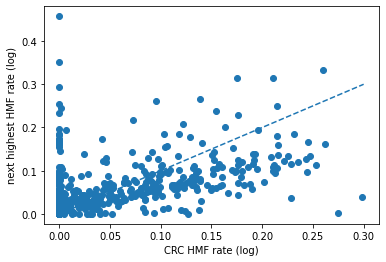

In [69]:
# plot crc hmf rate vs next highest hmf rate as measured by sample max
x = []
y = []
dist = []
names = []
for reg, rates in reg_dict.items():
    yi = np.log(max(rates[0:-1])+1)
    xi = np.log(rates[-1] + 1)
    x.append(xi)
    y.append(yi)
    dist.append(np.abs(xi - yi))
    #print(y)
    #names.append(reg["name"])
#     if reg==5:
#         break
plt.subplots()
# plt.xscale("log")
# plt.yscale("log")
plt.scatter(x,y)
plt.ylabel("next highest HMF rate (log)")
plt.xlabel("CRC HMF rate (log)")
plt.plot([0,0.30],[0,0.30], linestyle="--")

plt.subplots()
plt.scatter

(0.0, 0.1)

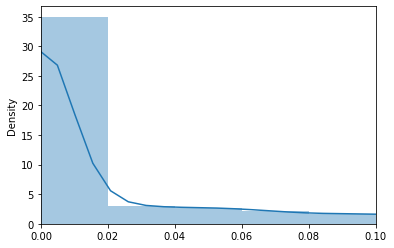

In [45]:
sns.distplot([r[-1] for r in reg_dict.values()])
plt.xlim([0,0.1])

<AxesSubplot:ylabel='Density'>

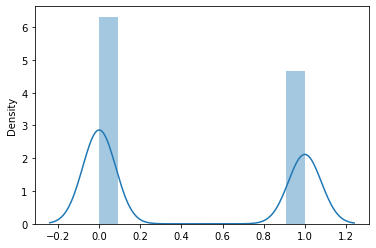

In [40]:
# calc region weights as the crc probability score of the next highest cancer methyl rate
# https://www.statology.org/poisson-distribution-python/
from scipy.stats import poisson
weights = {}
for reg, rates in reg_dict.items():
    if rates[-1] != 0:
        prob = poisson.pmf(k=max(rates[0:-1]), mu=rates[-1])
        weights[reg] = (1 - prob)  # the prob of being NOT crc-like
    else:
        weights[reg] = 0

sns.distplot(list(weights.values()))

In [5]:
def return_cancer_data(mat):
    region_spec = ChooseSettingsAndRegionsForPoissonSpecV2.voluptuous_validator(ChooseSettingsAndRegionsForPoissonSpecV2)\
                ({'name': 'choose_settings_and_regions_for_poisson_v2', 
                  'kwargs': {'desired_noise_floor': 1e-5, 'min_prob_clean': .95, 
                             'max_sigma_for_healthy_samples': 3.3, 'min_effect_size': 100.0, 'min_features' : 1, 'pessimistic_effect_size_ci': .95}})
    choose_regions = ChooseSettingsAndRegionsForPoissonV2.from_spec(region_spec)
    choose_regions.fit(mat)
    fitted_mat = choose_regions.select_best_features_per_region(x=mat.x, included_sample_dim=True)
    hmf_rates = fitted_mat[...,0]/fitted_mat[...,1] # do we want to use rates or counts here??????
    print(mat.column_metadata[0])
    regions = [f'{reg["chrm"]}:{reg["start"]}-{reg["stop"]}' for reg in mat.column_metadata]
    df_fitted_mat = pd.DataFrame(hmf_rates[mat.y==1], columns=regions)
    return df_fitted_mat

In [85]:
from scipy.stats import ttest_ind

# try running t-tests between sample distributions instead
region_spec = ChooseSettingsAndRegionsForPoissonSpecV2.voluptuous_validator(ChooseSettingsAndRegionsForPoissonSpecV2)\
                ({'name': 'choose_settings_and_regions_for_poisson_v2', 
                  'kwargs': {'desired_noise_floor': 1e-5, 'min_prob_clean': .95, 
                             'max_sigma_for_healthy_samples': 3.3, 'min_effect_size': 100.0, 'min_features' : 1, 'pessimistic_effect_size_ci': .95}})

choose_regions = ChooseSettingsAndRegionsForPoissonV2.from_spec(region_spec)

# store data (sample distributions) for CRC
mat_crc = mf.create_from_training_classes(training_classes=cancer_type_to_train_sets["CRC"] + healthy_plasma,
                                          feature_str='mint-chmcfc-multicancer-dsc/v6',
                                          class_labels=[1]*len(cancer_type_to_train_sets["CRC"]) + [0,0]
                                         )    
df_crc = return_cancer_data(mat_crc)

# run t-tests
reg_dict = defaultdict(list)
for cancer_type, tclasses in cancer_type_to_train_sets.items():
    if cancer_type == "CRC":
        continue
    print(cancer_type)
    # filter data to type-specific cpg cutoffs
    mat_noncrc = mf.create_from_training_classes(training_classes=tclasses + healthy_plasma,
                                          feature_str='mint-chmcfc-multicancer-dsc/v6',
                                          class_labels=[1]*len(tclasses) + [0,0]
                                         )    
    df_noncrc = return_cancer_data(mat_noncrc)
    for reg in list(df_noncrc.columns):
#         tstat, pval = ttest_ind(df_crc[reg], df_noncrc[reg], 
#                                 equal_var=False, nan_policy='omit', axis=0)
        #diff = np.mean(df_crc[reg]) - np.mean(df_noncrc[reg])
        #reg_dict[reg].append((diff, tstat, pval))
        #reg_dict[reg].append((np.median(df_crc[reg].values), tstat, pval))
        
        #hedge's G
        vals1 = [v for v in df_noncrc[reg] if ~np.isnan(v)]
        vals2 = [v for v in df_crc[reg] if ~np.isnan(v)]
        var1 = np.std(vals1)**2
        var2 = np.std(vals2)**2
        n1 = len(vals1)
        n2 = len(vals2)
        pooled_sd = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2))#https://www.statisticshowto.com/pooled-standard-deviation/
        hedges_g = (np.mean(vals1) - np.mean(vals2))/pooled_sd
        reg_dict[reg].append((np.median(df_crc[reg].values), hedges_g))

CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 72 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 24 case samples to fit on.


Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.


Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 21 case samples to fit on.


Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 20 case samples to fit on.


Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 25 case samples to fit on.


Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 26 case samples to fit on.


Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 11 case samples to fit on.


Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.


Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 17 case samples to fit on.


Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 9 case samples to fit on.


Lymphoma


CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 94 of 95 control samples. 1 samples were over 3.3 sigma.


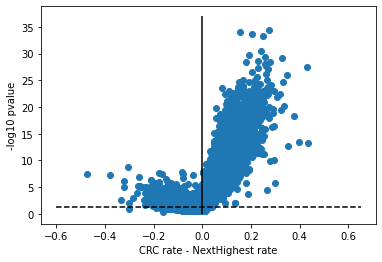

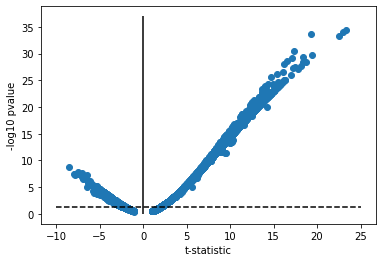

In [64]:
# volcano plot by min p-val region

diffs = []
pvals = []
tstats = []
regs = []
for reg, vals in reg_dict.items():
    #diff, tstat, pval = sorted(vals, key=lambda x: x[2])[0] # choose lowest pval region
    diff, tstat, pval = sorted(vals, key=lambda x: np.abs(x[1]))[-1] # choose highest t-stat region
    diffs.append(diff)
    pvals.append(pval)
    tstats.append(tstat)
    regs.append(reg)

# sns.distplot(diffs)
plt.subplots()
plt.scatter(diffs, -np.log10(pvals))
plt.xlabel("CRC rate - NextHighest rate")
plt.ylabel("-log10 pvalue")
plt.vlines(x=0, ymin=0, ymax=37, color="black")
plt.hlines(y=-np.log10(0.05), xmin=-0.6, xmax=0.65, linestyle="--", color="black")

plt.subplots()
plt.scatter(tstats, -np.log10(pvals))
plt.xlabel("t-statistic")
plt.ylabel("-log10 pvalue")
plt.vlines(x=0, ymin=0, ymax=37, color="black")
plt.hlines(y=-np.log10(0.05), xmin=-10, xmax=25, linestyle="--", color="black")


In [67]:
# output p-values to stats file and run weight regions transformer.
with open("./multicancer_region_ttest_pvals.txt", "w") as fout:
    fout.write("regions,tstat\n")
    for reg, tstat in zip(regs, tstats):
        if np.isnan(tstat):
            tstat = 0
        fout.write(f'{reg},{np.abs(tstat)}\n')
        
        

Text(0.5, 0, 'log10 crc hmf rate')

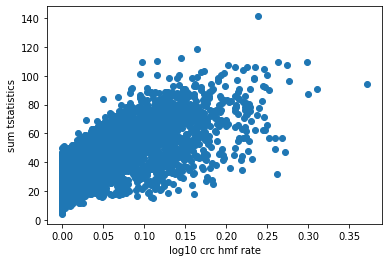

In [28]:
# try the sum of the tstatistics as a distance measure
x = []
y = []
dist = []
names = []
for reg, rates in reg_dict.items():
    crc_rate, _, _ = rates[-1]
    tstat_sum = np.sum([np.abs(tstat) for _,tstat,pval in rates[0:-1]])
    x.append(np.log(crc_rate + 1))
    y.append(tstat_sum)
    #names.append(reg["name"])
#     if reg==5:
#         break
plt.subplots()
# plt.xscale("log")
# plt.yscale("log")
plt.scatter(x,y)
plt.ylabel("sum tstatistics")
plt.xlabel("log10 crc hmf rate")
plt.xlim([0,0.4])
plt.ylim([0,145])
#plt.plot([0,0.30],[0,0.30], linestyle="--")

Text(0.5, 0, 'log10 crc hmf rate')

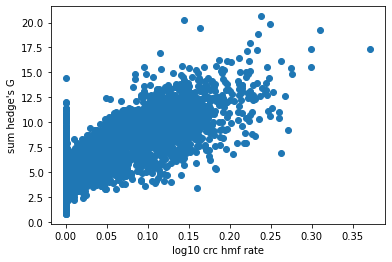

In [86]:
# try the sum of the hedges g's as a distance measure
x = []
y = []
dist = []
names = []
for reg, rates in reg_dict.items():
    crc_rate, _ = rates[-1]
    hg_sum = np.sum([np.abs(hg) for _,hg in rates[0:-1]])
    x.append(np.log(crc_rate + 1))
    y.append(hg_sum)
    #names.append(reg["name"])
#     if reg==5:
#         break
plt.subplots()
# plt.xscale("log")
# plt.yscale("log")
plt.scatter(x,y)
plt.ylabel("sum hedge's G")
plt.xlabel("log10 crc hmf rate")
# plt.xlim([0,0.4])
# plt.ylim([0,145])
#plt.plot([0,0.30],[0,0.30], linestyle="--")

## VP2 Panel Regions

In [21]:
## reproduce these plots on the same scale for the VP2 CRC SubPanel and the VP2 Full Panel. 
# How many CRC-specific regions to we have in these subsets vs. the multicancer regions.
# Answer the question, do we need to add more regions to reduce cross reactivity?


In [6]:
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader
from pineapple.contrib.results.inference_loader import InferenceResultWithMetadataLoader
from pineappleflow.core.loaders.contrib.inference import InferenceLoader
import os
from sklearn import metrics

In [112]:
# for each model plot sensitivity per cancer type
# see methods used for prev readout here: https://github.com/freenome/research_notebooks/blob/main/pineapple/methyl/multi_cancer/MultiCancerReport.report.ipynb

def plot_multicancer_sensitivities_from_inf(bucket, path, feature):
    loader = InferenceLoader(bucket, path)
    smeta = loader.inference_matrix_holder.sample_metadata
    scores = loader.aggregated_model_result.scores
    y = loader.inference_matrix_holder.y
    cancer_type = np.array([sm.cancer_type for idx,sm in enumerate(smeta)])
    print(Counter(cancer_type))
    stage = np.array([sm.stage for idx,sm in enumerate(smeta)])
    data = pd.DataFrame({"LogScores": np.log10(scores+1),"Stage": stage, "Scores": scores, "Label": y, "CancerType": cancer_type})
    call_rates = []
    types = []
    for i in sorted(list(set(data['CancerType']))):
        if "Cancer" not in i:
            continue
        types.append(i)
        subset = (data['Label'] == 0) | (data['CancerType'] == i)
        data_type = data[subset]
        cutoff90 = np.percentile(data_type[data_type['Label']==0]['Scores'], 90) # the score cutoff that yields 90%spec in the test set
        data_type['call90'] = [1 if score>=cutoff90 else 0 for score in data_type['Scores']]
        n_tp = np.sum([(true==1) and (call==1) for true,call in zip(data_type["Label"],data_type["call90"])])
        call_rates.append(n_tp/len(data_type[data_type["Label"]==1]))
        
        fpr, tpr, thresholds = metrics.roc_curve(data_type['Label'], data_type['Scores'])
        # correct last step in ROC curve to be compatible with discrete ROC curve
        tpr[-1] = tpr[-2]
        tpr = np.append(tpr,1.)
        fpr = np.append(fpr,1.)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{i} AUC:{'{0:.2}'.format(auc)}")
    plt.plot([0, 1], [0, 1],color='blue', alpha=0.5, linestyle='dashed', linewidth=1)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()
        
    fig, ax = plt.subplots()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.bar(types, call_rates, color=colors )
    plt.ylabel("Per Cancer Sensitivity @ 90 spec")
    plt.ylim([0,1])
    plt.title(os.path.basename(path))
    plt.xticks(types, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, call_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")


Counter({'Colorectal Normal / Healthy': 87, 'Pancreatic Cancer': 80, 'Normal / Healthy NOS': 75, 'Lung Cancer': 64, 'Prostate Cancer': 59, 'Ovarian Cancer': 57, 'Breast Cancer': 56, 'Esophageal Cancer': 56, 'Uterine Cancer': 54, 'Liver Cancer': 51, 'Pancreatic Normal / Healthy': 36, 'Pancreatic Pre-Cancer': 3, 'Unclassifiable': 1})


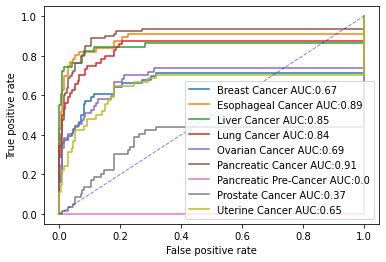

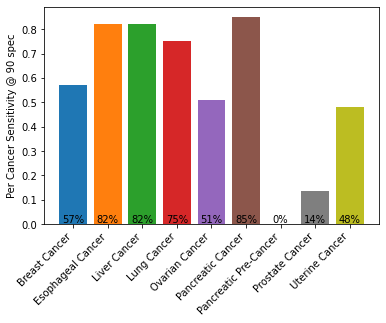

In [117]:
# april readout model using VP2 CRC subpanel regions
# freenome-user-data-peterulz/methyl/methyl_2021_q1/chmcfc_methyl_vp2_baseline/CHMFC_vp2_crossval_notissue
#inference run:
path = "MultiCancer/Apr23/VP2_inference_cancer1_neg0/methyl/methyl_2021_q1/chmcfc_methyl_vp2_baseline/CHMFC_vp2_crossval_notissue/fold_score_averaging/"
feature = "consecutive_hmcfc_methyl_vp2_automatic_regions_20201123/v1"
df_samples = plot_multicancer_sensitivities_from_inf(bucket="freenome-user-data-peterulz", 
                                                     path=path,
                                                     feature=feature)

Counter({'Colorectal Normal / Healthy': 87, 'Pancreatic Cancer': 80, 'Normal / Healthy NOS': 75, 'Lung Cancer': 64, 'Prostate Cancer': 59, 'Esophageal Cancer': 56, 'Uterine Cancer': 51, 'Ovarian Cancer': 50, 'Breast Cancer': 46, 'Liver Cancer': 39, 'Pancreatic Normal / Healthy': 36, 'Colorectal Cancer': 24, 'Pancreatic Pre-Cancer': 3, 'Unclassifiable': 1})


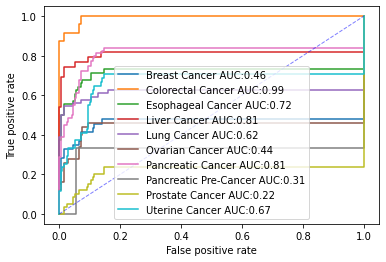

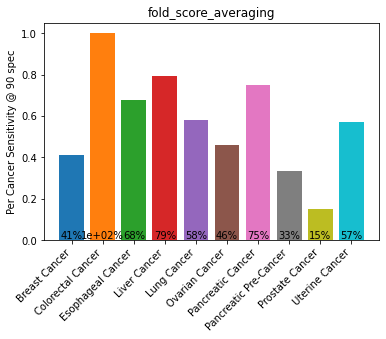

In [8]:
# model trained on CRC with all VP2 regions
# model: pf train --bucket freenome-user-data-bgould --path Multi_cancer/CRC_spec_filtering/20210726 --spec CRC_CHMFC_VP2_trained_model.yaml
# inference:
# freenome-user-data-bgould/Multi_cancer/CRC_spec_filtering/20210726/Multi_cancer/CRC_spec_filtering/20210726/CRC_CHMFC_VP2_trained/fold_score_averaging
path = "Multi_cancer/CRC_spec_filtering/20210726/Multi_cancer/CRC_spec_filtering/20210726/CRC_CHMFC_VP2_trained/fold_score_averaging"
feature = "mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1"
plot_multicancer_sensitivities_from_inf(bucket="freenome-user-data-bgould", 
                                        path=path,
                                        feature=feature)

Counter({'Colorectal Normal / Healthy': 87, 'Pancreatic Cancer': 80, 'Normal / Healthy NOS': 75, 'Lung Cancer': 64, 'Prostate Cancer': 59, 'Esophageal Cancer': 56, 'Uterine Cancer': 51, 'Ovarian Cancer': 50, 'Breast Cancer': 46, 'Liver Cancer': 39, 'Pancreatic Normal / Healthy': 36, 'Colorectal Cancer': 24, 'Pancreatic Pre-Cancer': 3, 'Unclassifiable': 1})


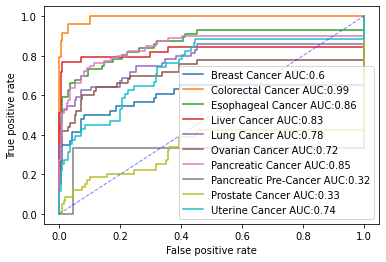

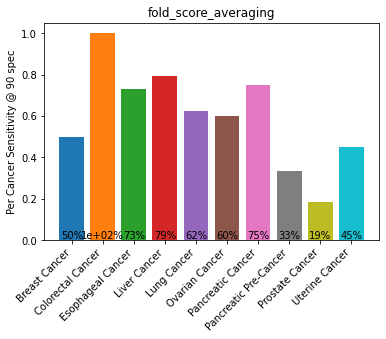

In [9]:
# model trained on CRC with 9030 Multicancer regions
# model: pf train --bucket freenome-user-data-bgould --path Multi_cancer/CRC_spec_filtering/20210726 --spec CRC_CHMFC_MulicancerReg_trained_model.yaml
# inference:
# freenome-user-data-bgould/Multi_cancer/CRC_spec_filtering/20210726/Multi_cancer/CRC_spec_filtering/20210726/CRC_CHMFC_MulticancerReg_trained/fold_score_averaging
path = "Multi_cancer/CRC_spec_filtering/20210726/Multi_cancer/CRC_spec_filtering/20210726/CRC_CHMFC_MulticancerReg_trained/fold_score_averaging"
feature = "mint-chmcfc-multicancer-dsc/v6"
plot_multicancer_sensitivities_from_inf(bucket="freenome-user-data-bgould", 
                                        path=path,
                                        feature=feature)

## Filter VP2 and Multicancer regions by Hedge's G

In [22]:
# create metadata for VP2 region feature
dim_regions = []
dim_thresholds = np.array([{'cpgs':i} for i in range(3,34)])
dim_counts = np.array([{"mcpgs":'mcpgs'},{"tcpgs":'tcpgs'}])
with open("./CpG_denseV2_intersect_VP2.bed","r") as fin:
    for line in fin:
        chrm, start, stop = line.split()
        dim_regions.append({"chrm":chrm, "start":start, "stop":stop.strip()})


FeatureIO().update_column_metadata(feature='mint-chmcfc-VP2-intersect-CpGV2-dsc_v1',
                                version=1,
                                column_metadata = (dim_regions, dim_thresholds, dim_counts))


True

In [83]:
a = np.array([[1,2,3],[4,5,6]])
b = a[...,2] + 1
b

array([4, 7])

In [104]:
# calc hedges's G distances

def _fill_nan(rates: list):
    vals = [v for v in rates if ~np.isnan(v)]
    fill_val = np.median(vals)
    return np.median([r if ~np.isnan(r) else fill_val for r in rates])

def return_cancer_data(mat):
    region_spec = ChooseSettingsAndRegionsForPoissonSpecV2.voluptuous_validator(ChooseSettingsAndRegionsForPoissonSpecV2)\
                ({'name': 'choose_settings_and_regions_for_poisson_v2', 
                  'kwargs': {'desired_noise_floor': 1e-5, 'min_prob_clean': .95, 
                             'max_sigma_for_healthy_samples': 3.3, 'min_effect_size': 100.0,'pessimistic_effect_size_ci': .95}})
    choose_regions = ChooseSettingsAndRegionsForPoissonV2.from_spec(region_spec)
    choose_regions.fit(mat)
    fitted_mat = choose_regions.select_best_features_per_region(x=(mat.x).astype('int'), included_sample_dim=True)
    hmf_rates = fitted_mat[...,0]/(fitted_mat[...,1]+1)
    regions = [f'{reg["chrm"]}:{reg["start"]}-{reg["stop"]}' for reg in mat.column_metadata]
    df_hmf_rates = pd.DataFrame(hmf_rates[mat.y==1], columns=regions)
    return df_hmf_rates

def get_hedgesG(feature):
    mat_crc = mf.create_from_training_classes(training_classes=cancer_type_to_train_sets["CRC"] + healthy_plasma,
                                              feature_str=feature,
                                              class_labels=[1]*len(cancer_type_to_train_sets["CRC"]) + [0,0]
                                             )    
    df_crc = return_cancer_data(mat_crc)
    reg_dict = defaultdict(list)
    for cancer_type, tclasses in cancer_type_to_train_sets.items():
        if cancer_type == "CRC":
            continue
        print(cancer_type)
        # filter data to type-specific cpg cutoffs
        mat_noncrc = mf.create_from_training_classes(training_classes=tclasses + healthy_plasma,
                                              feature_str=feature,
                                              class_labels=[1]*len(tclasses) + [0,0]
                                             )    
        df_noncrc = return_cancer_data(mat_noncrc)
        #print(df_noncrc.head)
        for reg in list(df_noncrc.columns):
            #hedge's G
            vals1 = [v for v in df_crc[reg] if ~np.isnan(v)]
            vals2 = [v for v in df_noncrc[reg] if ~np.isnan(v)]
            var1 = np.std(vals1)**2
            var2 = np.std(vals2)**2
            n1 = len(vals1)
            n2 = len(vals2)
            pooled_sd = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2))#https://www.statisticshowto.com/pooled-standard-deviation/
            hedges_g = (np.mean(vals1) - np.mean(vals2))/pooled_sd # neg values -> crc is hypomethylated
            reg_dict[reg].append((np.median(_fill_nan(df_crc[reg])), hedges_g))
        
    return reg_dict #one entry per region, each a list of tuples (crc_median,HG) one per cancer type

In [ ]:
# why is the lung data missing? Never resolved this :-(
tc = ["lung_cancer_methyl_DMR_tissue_ds_FF_merged"]
#tc = ["pancreatic_cancer_tissue_ds_FF_v1"]
mat_lung = mf.create_from_training_classes(tc + healthy_plasma,
                                           feature_str="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1",
                                           class_labels=[1,0,0]
                                          )
#print(mat_lung.x[0:3,0:1])
return_cancer_data(mat_lung)


In [137]:
# try hedges g's as a distance measure
reg_dict = get_hedgesG(feature='mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1')

CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 72 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 12 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Lung_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 13 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Liver_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 23 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Prostate_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 20 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Ovarian_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 25 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Uterine_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 26 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Pancreatic_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 11 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Breast_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 14 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Stomach_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 19 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Kidney_Cancer


CHOOSE SETTINGS AND REGIONS FOR POISSON: Found 8 case samples to fit on.
CHOOSE SETTINGS AND REGIONS FOR POISSON: Using: 93 of 95 control samples. 2 samples were over 3.3 sigma.


Lymphoma


[('chr1:2443379-2444375', [(0.022444288412992962, -10.573838885545648), (0.022444288412992962, 0.7967334129887766), (0.022444288412992962, 0.8812601933062165), (0.022444288412992962, 0.839995575616337), (0.022444288412992962, 0.2695229118280462), (0.022444288412992962, 0.5105350456818137), (0.022444288412992962, 0.8134254476942576), (0.022444288412992962, 0.1103979130695382), (0.022444288412992962, 0.539782498999727), (0.022444288412992962, -0.5476113557222234)]), ('chr1:3393377-3394370', [(0.0, -252.28515523302792), (0.0, -0.6722113689758891), (0.0, 0.2643616157552079), (0.0, -0.19245099970974855), (0.0, -0.5062073044567288), (0.0, -2.6416169613073675), (0.0, -0.18379468680378683), (0.0, -0.29465811336157377), (0.0, 0.2656835722477823), (0.0, -2.0261194878033595)]), ('chr1:3746399-3747767', [(0.029771398192450824, -26.804507403199345), (0.029771398192450824, 1.1189879492877277), (0.029771398192450824, 1.2117514553242832), (0.029771398192450824, 1.15786389652848), (0.029771398192450824

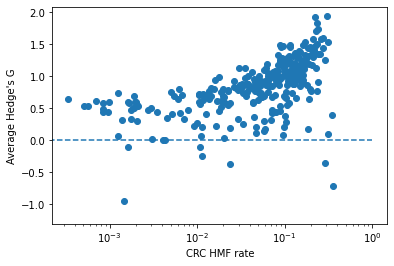

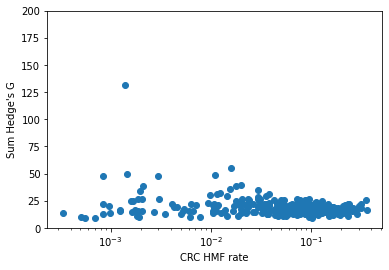

In [138]:
print(list(reg_dict.items())[0:5])

x = []
y_sum = []
y_avg = []
dist = []
names = []
for reg, rates in reg_dict.items():
    crc_rate, _ = rates[-1]
    hg_sum = np.sum([np.abs(hg) for _,hg in rates[0:-1]])
    hg_avg = np.median([hg for _,hg in rates[0:-1]]) # crc is hypomethylated when hg<0. downweight these.
    x.append(crc_rate)
    y_sum.append(hg_sum)
    y_avg.append(hg_avg)
    names.append(reg)

plt.subplots()
plt.xscale("log")
# plt.yscale("log")
plt.scatter(x,y_avg)
plt.ylabel("Average Hedge's G")
plt.xlabel("CRC HMF rate")
plt.hlines(xmin=0, xmax=1, y=0,linestyle="--")
# plt.xlim([0,0.4])
# plt.ylim([0,145])
#plt.plot([0,0.30],[0,0.30], linestyle="--")

plt.subplots()
plt.xscale("log")
# plt.yscale("log")
plt.scatter(x,y_sum)
plt.ylabel("Sum Hedge's G")
plt.xlabel("CRC HMF rate")
plt.ylim([0,200])

with open("./mint-chmcfc-VP2-intersect-CpGV2-dsc_v1_weights.csv","w") as fout:
    fout.write("regions,total_abs_hedges_g,neg_avg_hedges_g\n")
    for reg,a,b in zip(names,y_sum,y_avg):
        if np.isnan(b):
            b = 0
        fout.write(f"{reg},{a},{b}\n")


In [ ]:
# downweight regions that are relatively hypermethylated in other cancers (HG positive)
# upweight relatively hypomethylated cancers (HG negative)
# or use absv of HG in a logistic regression

Counter({'Colorectal Normal / Healthy': 87, 'Pancreatic Cancer': 80, 'Normal / Healthy NOS': 75, 'Lung Cancer': 64, 'Prostate Cancer': 59, 'Esophageal Cancer': 56, 'Uterine Cancer': 51, 'Ovarian Cancer': 50, 'Breast Cancer': 46, 'Liver Cancer': 39, 'Pancreatic Normal / Healthy': 36, 'Colorectal Cancer': 24, 'Pancreatic Pre-Cancer': 3, 'Unclassifiable': 1})


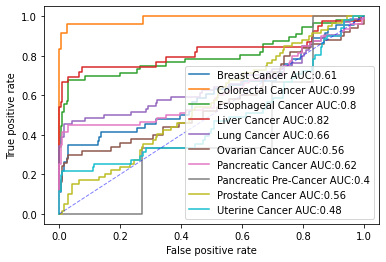

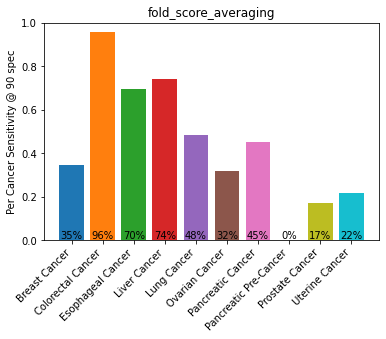

In [139]:
# train a VP2 model with regions weighted by hedges's G
# pineapple --out_bucket freenome-user-data-bgould --out_path Multi_cancer/CRC_spec_filtering/20210726 --spec CRC_CHMFC_VP2_trained_model_filtW.yaml
# infer:
path = "Multi_cancer/CRC_spec_filtering/20210726/Multi_cancer/CRC_spec_filtering/20210726/CRC_CHMFC_VP2_trained_filt10/fold_score_averaging"
feature = "mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1"
plot_multicancer_sensitivities_from_inf(bucket="freenome-user-data-bgould", 
                                        path=path,
                                        feature=feature)

In [115]:
## the weighting only works when min features is high enough. otherwise all weights can eaasily be 0.
## try running some models while varying min features, see if cr goes down with more regions. can also try the 
## multicancer panel of regions. # and fix weights transformer with a PR and let vrinda know. 

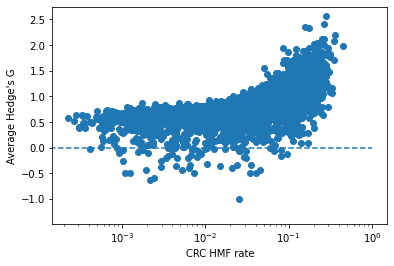

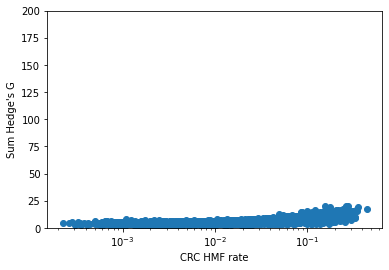

In [133]:
# weight the multicancer regions

#reg_dict = get_hedgesG(feature = "mint-chmcfc-multicancer-dsc/v6")

#print(list(reg_dict.items())[0:5])

x = []
y_sum = []
y_avg = []
dist = []
names = []
for reg, rates in reg_dict.items():
    crc_rate, _ = rates[-1]
    hg_sum = np.sum([np.abs(hg) for _,hg in rates[0:-1]])
    hg_avg = np.median([hg for _,hg in rates[0:-1]]) # crc is hypomethylated when hg<0. 
    x.append(crc_rate)
    y_sum.append(hg_sum)
    y_avg.append(hg_avg)
    names.append(reg)

plt.subplots()
plt.xscale("log")
# plt.yscale("log")
plt.scatter(x,y_avg)
plt.ylabel("Average Hedge's G")
plt.xlabel("CRC HMF rate")
plt.hlines(xmin=0, xmax=1, y=0,linestyle="--")
# plt.xlim([0,0.4])
# plt.ylim([0,145])
#plt.plot([0,0.30],[0,0.30], linestyle="--")

plt.subplots()
plt.xscale("log")
# plt.yscale("log")
plt.scatter(x,y_sum)
plt.ylabel("Sum Hedge's G")
plt.xlabel("CRC HMF rate")
plt.ylim([0,200])

with open("./mint-chmcfc-multicancer-dsc_v6_weights.csv","w") as fout:
    fout.write("regions,total_abs_hedges_g,neg_avg_hedges_g\n")
    for reg,a,b in zip(names,y_sum,y_avg):
        if np.isnan(b):
            b = 0
        fout.write(f"{reg},{a},{b}\n")

Counter({'Colorectal Normal / Healthy': 87, 'Pancreatic Cancer': 80, 'Normal / Healthy NOS': 75, 'Lung Cancer': 64, 'Prostate Cancer': 59, 'Esophageal Cancer': 56, 'Uterine Cancer': 51, 'Ovarian Cancer': 50, 'Breast Cancer': 46, 'Liver Cancer': 39, 'Pancreatic Normal / Healthy': 36, 'Colorectal Cancer': 24, 'Pancreatic Pre-Cancer': 3, 'Unclassifiable': 1})


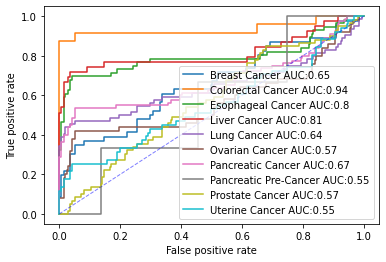

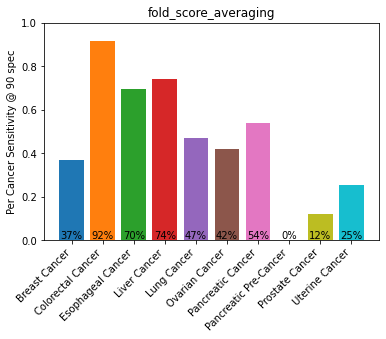

In [140]:
# train a MulticancerReg model with regions weighted by hedges's G
# pineapple --out_bucket freenome-user-data-bgould --out_path Multi_cancer/CRC_spec_filtering/20210726 --spec CRC_CHMFC_MulticancerReg_trained_model_filtW.yaml
# infer:
path = "Multi_cancer/CRC_spec_filtering/20210726/Multi_cancer/CRC_spec_filtering/20210726/CRC_CHMFC_MulticancerReg_trained_filt10/fold_score_averaging"
feature = "mint-chmcfc-multicancer-dsc/v6"
plot_multicancer_sensitivities_from_inf(bucket="freenome-user-data-bgould", 
                                        path=path,
                                        feature=feature)

Counter({'Colorectal Normal / Healthy': 87, 'Pancreatic Cancer': 80, 'Normal / Healthy NOS': 75, 'Lung Cancer': 64, 'Prostate Cancer': 59, 'Esophageal Cancer': 56, 'Uterine Cancer': 51, 'Ovarian Cancer': 50, 'Breast Cancer': 46, 'Liver Cancer': 39, 'Pancreatic Normal / Healthy': 36, 'Colorectal Cancer': 24, 'Pancreatic Pre-Cancer': 3, 'Unclassifiable': 1})


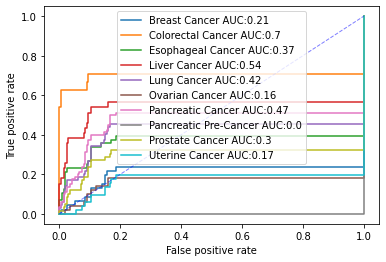

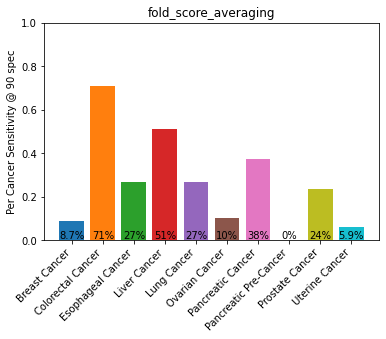

In [126]:
# train a VP2 model with multicancer tissues as negatives. (no reg weighting)
# pineapple --out_bucket freenome-user-data-bgould --out_path Multi_cancer/CRC_spec_filtering/20210726 --spec Multicancer_CHMFC_VP2_trained_model.yaml --skip_analysis_hooks
# infer:
path = "Multi_cancer/CRC_spec_filtering/20210726/Multi_cancer/CRC_spec_filtering/20210726/Multicancer_CHMFC_VP2_trained/fold_score_averaging"
feature = "mint-chmcfc-multicancer-dsc/v6"
plot_multicancer_sensitivities_from_inf(bucket="freenome-user-data-bgould", 
                                        path=path,
                                        feature=feature)

Counter({'Colorectal Normal / Healthy': 87, 'Pancreatic Cancer': 80, 'Normal / Healthy NOS': 75, 'Lung Cancer': 64, 'Prostate Cancer': 59, 'Esophageal Cancer': 56, 'Uterine Cancer': 51, 'Ovarian Cancer': 50, 'Breast Cancer': 46, 'Liver Cancer': 39, 'Pancreatic Normal / Healthy': 36, 'Colorectal Cancer': 24, 'Pancreatic Pre-Cancer': 3, 'Unclassifiable': 1})


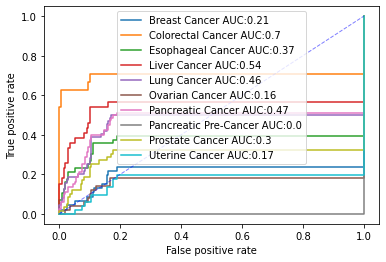

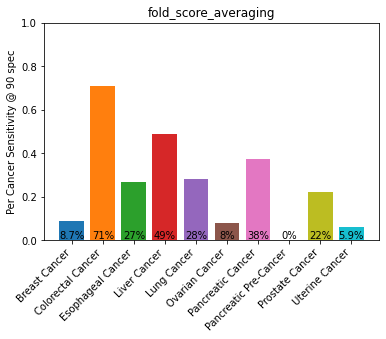

In [141]:
# train a VP2 model with multicancer tissues as negatives. ##Use min regions == 551 (full panel)
# 
# infer:
path = "Multi_cancer/CRC_spec_filtering/20210726/Multi_cancer/CRC_spec_filtering/20210726/Multicancer_CHMFC_VP2_trained_551reg/fold_score_averaging"
feature = "mint-chmcfc-multicancer-dsc/v6"
plot_multicancer_sensitivities_from_inf(bucket="freenome-user-data-bgould", 
                                        path=path,
                                        feature=feature)

In [ ]:
# modeling moving forward
# log reg with two features, use features from 100bp binning 
# fingerprinting - for each cancer tissue identify regions that are on. for each cancer type, fit a classifier to give prob of that cancer type
#.  ??? plot plasmahmf/tissuehmf healthmf/tissuehmf for each region, ON = >90th% of healthies,
    #--In notebook generate region signature for each cancer type from tissue:
        #--what regions are ON in tissue?
            #--regions methylated over 90%ile of healthies
            #--regions that have a high mean carryover to plasma
            #--regions with significant coefficients in a single tissue log reg
    #--In pineapple transformer, create a signature for each test plasma sample
        #--each region on/off 1/0 to create a sample vector
    #--Calculate distance between each sample vector and each tissue vector (cross entropy?)
        #--output closest cancer type.
        #--threshold cancer/no cancer on min distance(max entropy) score
        #--if cancer, output TOO. if healthy output healthy.
    

# probability - for each region build a probability distribution for each cancer type using tissue. 
#. for each plasma sample predict the probabilities for each region. Sum across all regions for each cancer type to 
# get max p(cancer_type). 